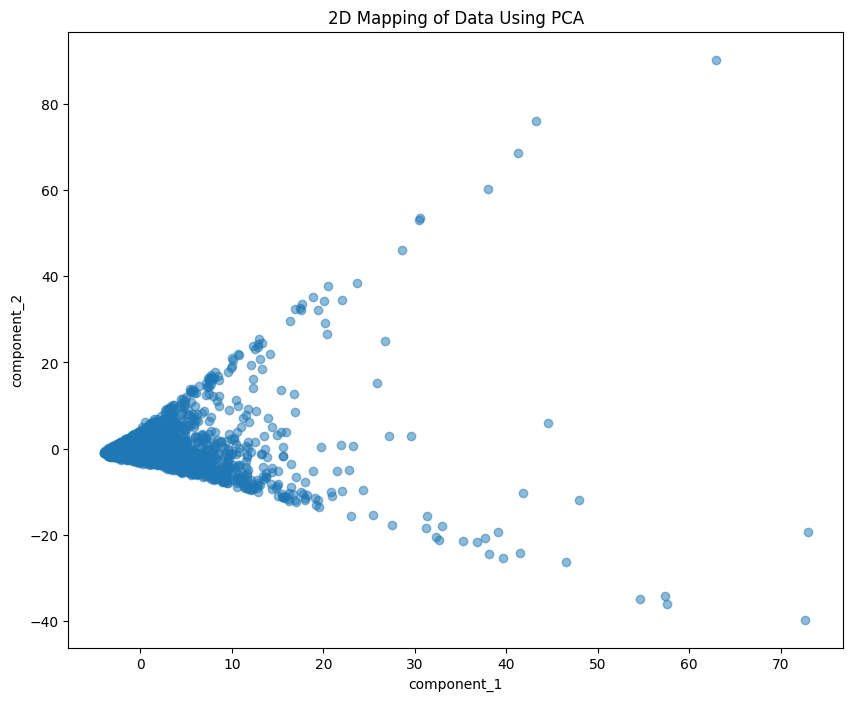

In [1]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

def reduce_dims(df, dims=2, method='pca', perplexity=30):

    assert method in ['pca', 'tsne'], 'Неверно указан метод'

    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')

    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames)

# Загрузка данных
df = pd.read_csv('Credit Card Dataset.csv', sep=',')
df = df.dropna()
feature_names = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 
                 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 
                 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
                 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 
                 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

X = df[feature_names]

# Масштабирование данных
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Снижение размерности до 2-х компонентов с помощью PCA
dim_reducer, components_df = reduce_dims(pd.DataFrame(X_scaled), dims=2, method='pca')

# Визуализация полученных компонент
plt.figure(figsize=(10, 8))
plt.scatter(components_df['component_1'], components_df['component_2'], alpha=0.5)
plt.xlabel('component_1')
plt.ylabel('component_2')
plt.title('2D Mapping of Data Using PCA')
plt.show()


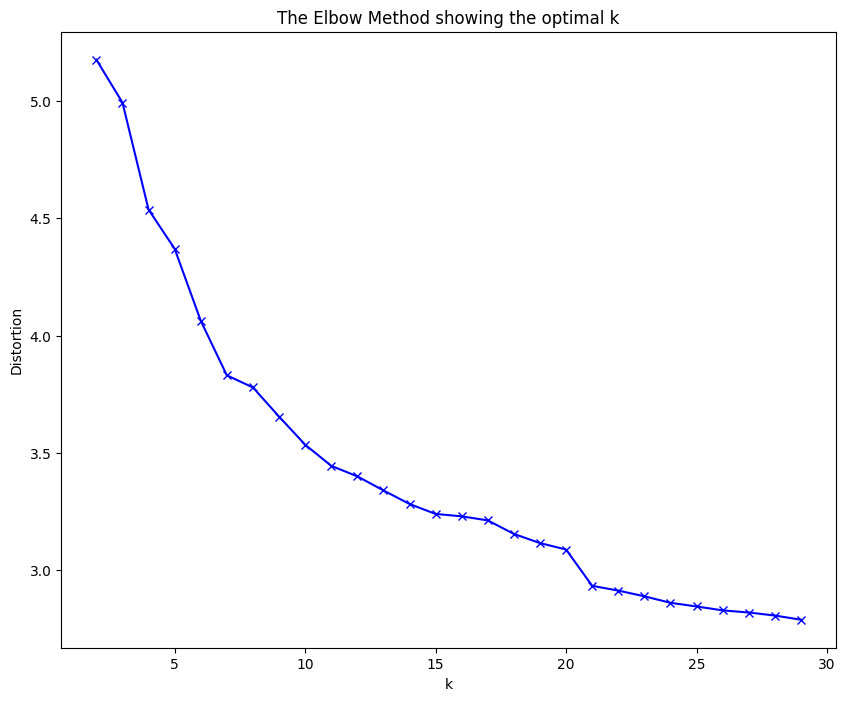

In [2]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

def apply_elbow_method(X):
    distortions = []
    K = range(2, 30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

# Применяем метод локтя для данных
apply_elbow_method(X_scaled)

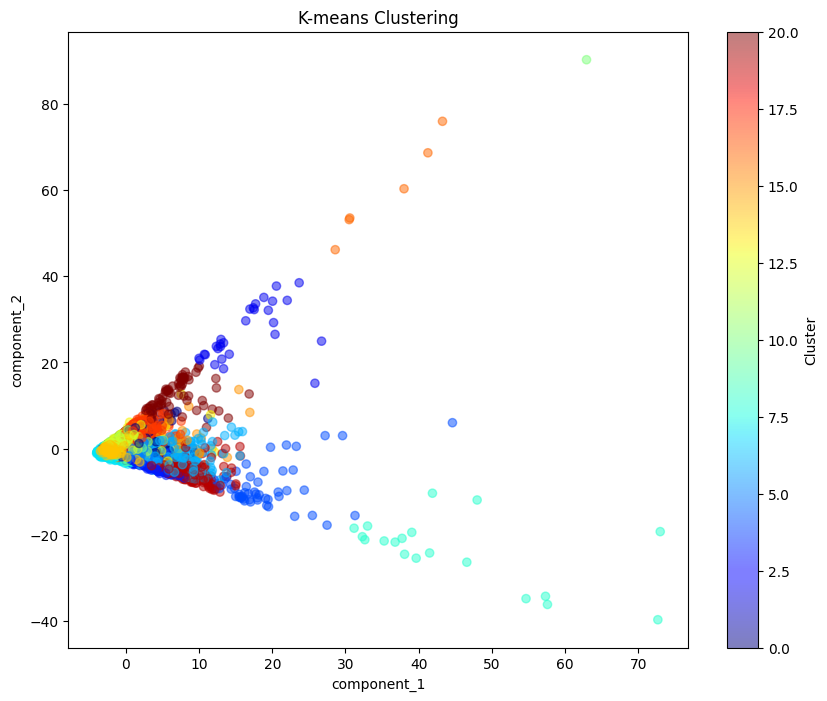

In [11]:
k = 21
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Визуализируем результаты кластеризации
components_df['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))
plt.scatter(components_df['component_1'], components_df['component_2'], c=components_df['cluster'], cmap='jet', alpha=0.5)
plt.xlabel('component_1')
plt.ylabel('component_2')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()

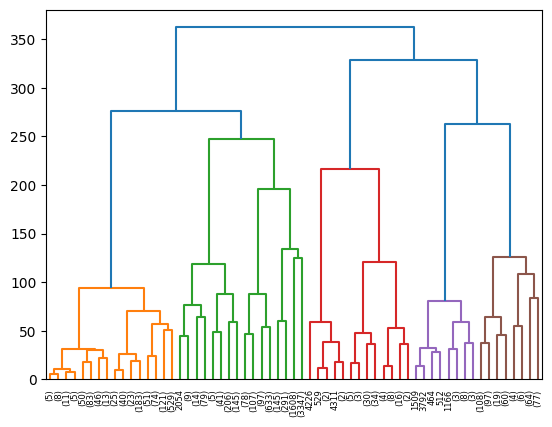

In [12]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
aggl = AgglomerativeClustering(n_clusters=25, compute_distances=True)
aggl.fit(X_scaled)
plot_dendrogram(aggl, truncate_mode='level', p=5)

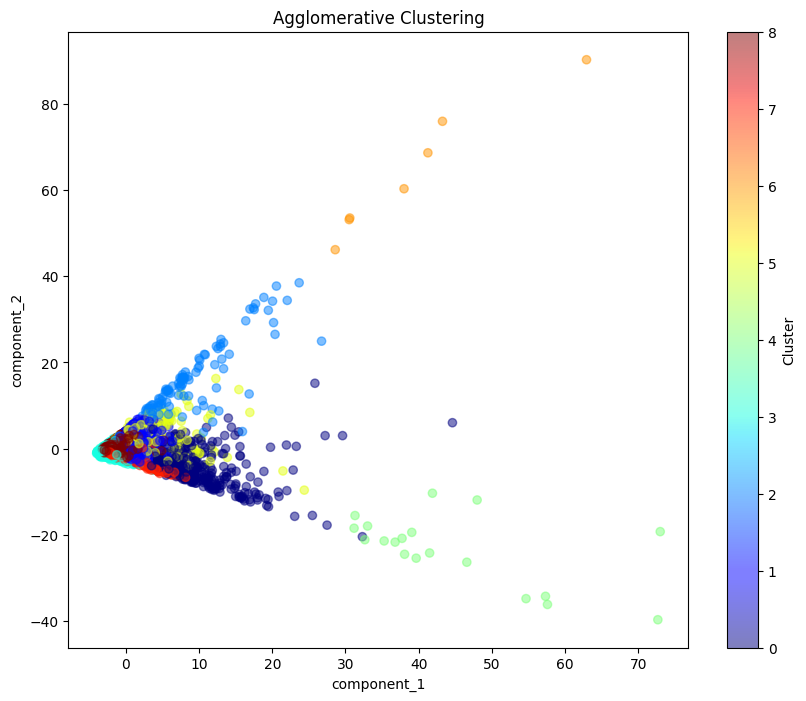

In [13]:
from sklearn.cluster import AgglomerativeClustering

# Применяем агломеративную кластеризацию
agglo = AgglomerativeClustering(n_clusters=9)
agglo_labels = agglo.fit_predict(X_scaled)

# Визуализируем результаты агломеративной кластеризации
components_df['agglo_cluster'] = agglo_labels

plt.figure(figsize=(10, 8))
plt.scatter(components_df['component_1'], components_df['component_2'], c=components_df['agglo_cluster'], cmap='jet', alpha=0.5)
plt.xlabel('component_1')
plt.ylabel('component_2')
plt.title('Agglomerative Clustering')
plt.colorbar(label='Cluster')
plt.show()

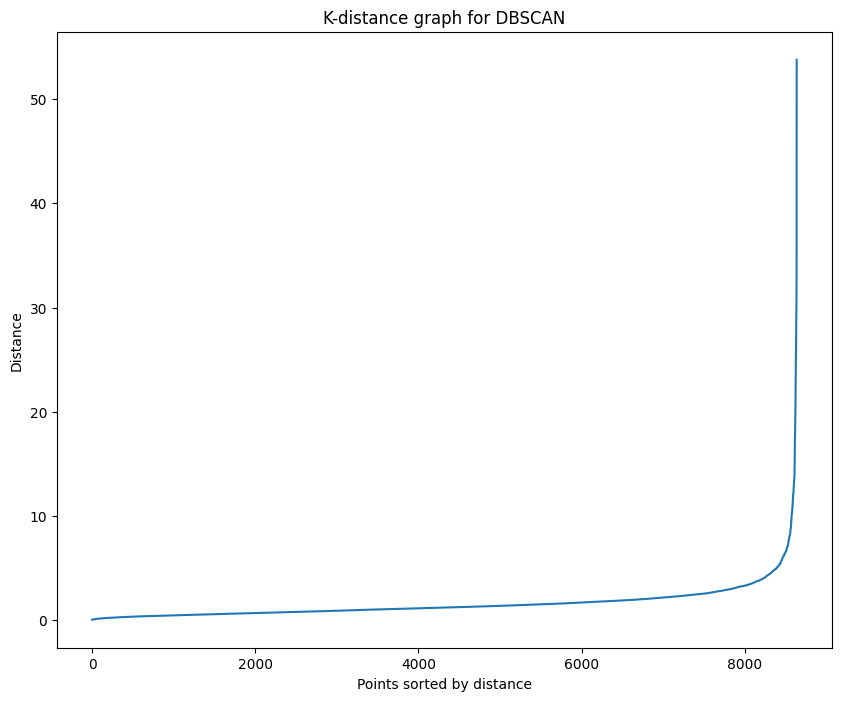

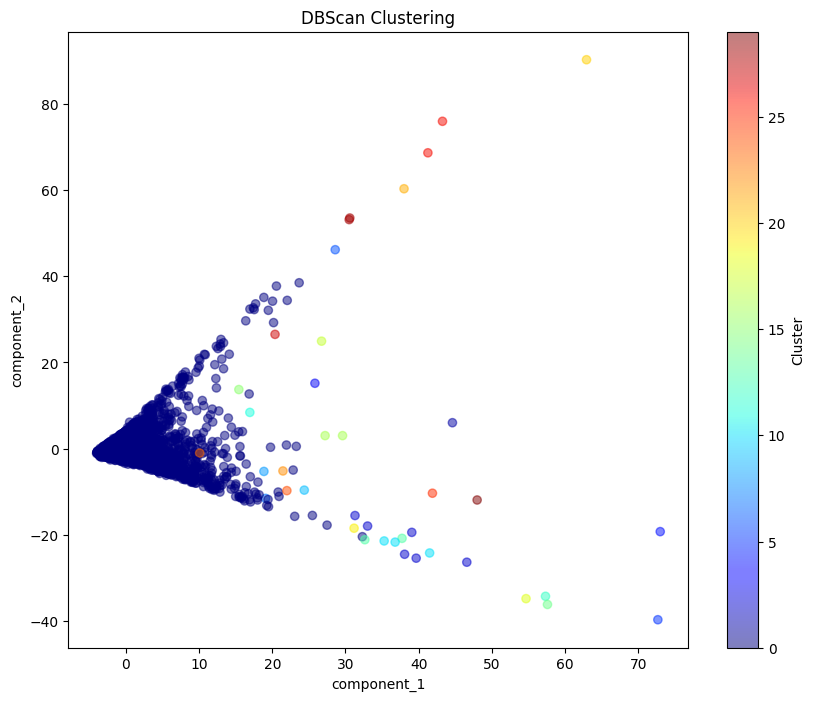

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Используем NearestNeighbors для определения оптимального eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Строим график расстояний для выбора eps
distances = np.sort(distances[:,4], axis=0)
plt.figure(figsize=(10, 8))
plt.plot(distances)
plt.title('K-distance graph for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.show()

# Выбираем eps, например 0.3, и min_samples, например 5
dbscan = DBSCAN(eps=10, min_samples=1)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Визуализируем результаты DBScan
components_df['dbscan_cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
plt.scatter(components_df['component_1'], components_df['component_2'], c=components_df['dbscan_cluster'], cmap='jet', alpha=0.5)
plt.xlabel('component_1')
plt.ylabel('component_2')
plt.title('DBScan Clustering')
plt.colorbar(label='Cluster')
plt.show()